# Logistic Regression as a Neural Network

### Importing necessary packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py # package for interacting with a dataset that is stored on an H5 file
# import scipy
from PIL import Image # Python Imaging Library
from scipy import ndimage # PIL & SciPy will be used to test the model with any picture at the end

%matplotlib inline

### Defining a function for loading training and test datasets

In [2]:
def load_dataset():
    train_dataset = h5py.File('train_dataset.h5', "r")
    train_set_x_init = np.array(train_dataset["train_set_x"][:]) # our training set features
    train_set_y_init = np.array(train_dataset["train_set_y"][:]) # our training set labels

    test_dataset = h5py.File('test_dataset.h5', "r")
    test_set_x_init = np.array(test_dataset["test_set_x"][:]) # our test set features
    test_set_y_init = np.array(test_dataset["test_set_y"][:]) # our test set labels

    classes = np.array(test_dataset["list_classes"][:]) # list of classes
    
    train_set_y_init = train_set_y_init.reshape((1, train_set_y_init.shape[0]))
    test_set_y_init = test_set_y_init.reshape((1, test_set_y_init.shape[0]))
    
    return train_set_x_init, train_set_y_init, test_set_x_init, test_set_y_init, classes


### Notes on datasets-images

- We have a training set of m_train images labelled as cat (y=1) or non-cat (y=0)
- We have a test set of m_test images labelled as cat or non-cat
- Each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB). Thus, each image is square (height = num_px and width = num_px).

In [3]:
# Loading the data
train_set_x_init, train_set_y, test_set_x_init, test_set_y, classes = load_dataset()

In [4]:
# type(train_set_x_init)

y = [0], this is a 'non-cat' picture.


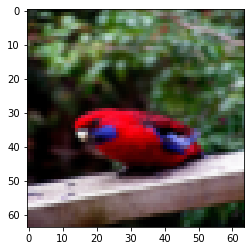

In [5]:
# Example of a picture
index = 35
plt.imshow(train_set_x_init[index])
print(f"y = {str(train_set_y[:, index])}, this is a '{classes[np.squeeze(train_set_y[:, index])].decode('utf-8')}' picture.")

In [6]:
# train_set_x_init is a numpy array of shape (m_train, num_px, num_px, 3)
m_train = train_set_x_init.shape[0] # number of training examples
m_test = test_set_x_init.shape[0] # number of test examples
num_px = train_set_x_init.shape[1] # num_px is the height and width of a training image

print("Number of training examples: m_train = " + str(m_train))
print("Number of testing examples: m_test = " + str(m_test))
print("Height/Width of each image: num_px = " + str(num_px))
print("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print("train_set_x shape: " + str(train_set_x_init.shape))
print("train_set_y shape: " + str(train_set_y.shape))
print("test_set_x shape: " + str(test_set_x_init.shape))
print("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


In [7]:
# train_set_x_init

### Reshaping images

__Note__: We will now reshape every image of shape (num_px, num_px, 3) in a numpy array of shape (num_px $*$ num_px $*$ 3, 1), so that our training and test datasets are numpy arrays where each column represents a flattened image. There should be m_train (and respectively m_test) columns.

In [8]:
train_set_x_init[0][0][0:5]

array([[17, 31, 56],
       [22, 33, 59],
       [25, 35, 62],
       [25, 35, 62],
       [27, 36, 64]], dtype=uint8)

In [9]:
# Reshaping the training and test datasets so that images of size (num_px, num_px, 3) are flattened into single vectors of shape (num_px * num_px * 3, 1)

train_set_x_flatten = train_set_x_init.reshape(train_set_x_init.shape[0],train_set_x_init.shape[1]*
                                               train_set_x_init.shape[2]*
                                              train_set_x_init.shape[3]).T
# OR
# train_set_x_flatten = train_set_x_init.reshape(train_set_x_init.shape[0],-1).T
test_set_x_flatten = test_set_x_init.reshape(test_set_x_init.shape[0],-1).T

print("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print("train_set_y shape: " + str(train_set_y.shape))
print("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print("test_set_y shape: " + str(test_set_y.shape))
print("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [17 31 56 22 33]


### Standardizing our dataset

__Note__: To represent color images, the red, green and blue channels (RGB) must be specified for each pixel, meaning that the pixel value is actually a vector of three numbers ranging from 0 to 255.

A common preprocessing step in machine learning is to center and standardize our dataset, meaning that we substract the mean of the entire numpy array from each example, and then divide each example by the standard deviation of the entire numpy array. For picture datasets though, it is simpler and more convenient and it works almost as well to just divide every row of the dataset by 255 (the maximum value of a pixel channel).

When we train our model, we will multiply weights and add biases to some initial inputs in order to observe neuron activations. Then we will backpropogate with the gradients to train the model. It is extremely important though to have a similar range for each feature so that our gradients do not explode.

In [10]:
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

In [11]:
# train_set_x[0:5,0]

## General architecture of the learning algorithm

We will now design a simple algorithm to distinguish cat images from non-cat images.


For one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b $$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})$$

We then compute the cost by summing over all the training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})$$
    
## Main steps for building and utilising a Neural Network

1. Definition of the model's structure (e.g. number of input features) 
2. Initialization of the model's parameters
3. Iterative process (loop) for training the parameters:
    - Calculation of current loss (forward propagation)
    - Calculation of current gradient (backward propagation)
    - Update of parameters (using gradient descent to minimize the cost)
4. Predictions on the test set (using the learned parameters)
5. Analysis of results and conclusions

## Building helper functions

__Note__: We need to compute the sigmoid function to make predictions.

$sigmoid( w^T x + b) = \frac{1}{1 + e^{-(w^T x + b)}}$

In [12]:
def sigmoid(z):
    """
    Computes the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Returns:
    s -- sigmoid(z)
    """
    s = 1 / (1 + np.exp(-z))    
    return s

In [13]:
# print(sigmoid(np.array([0,5])))

### Initializing parameters

In [14]:
# train_set_x_flatten.shape[0]

In [15]:
def initialize(dim):
    """
    Creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (number of parameters)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """    
#     w = np.zeros((train_set_x_flatten.shape[0],1))
    w = np.zeros((dim,1))
    b = 0

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

In [16]:
dim = 2
w, b = initialize(dim)
print("w = " + str(w))
print("b = " + str(b))

w = [[0.]
 [0.]]
b = 0


### Forward and Backward propagation

After initializing our parameters, we can implement the "forward" and "backward" propagation steps for learning the parameters.

Forward Propagation:
- We get X
- We compute $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- We calculate the loss function: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

The two formulas we will be using are as follows:

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})$$

In [17]:
def propagate(w, b, X, Y):
    """
    Implements the cost function and its gradient for the feedforward and backward propagation

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- labels vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Returns:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w (of the same shape as w)
    db -- gradient of the loss with respect to b (of the same shape as b)
    """
    
    m = X.shape[1]
    
    # forward propagation
    A = sigmoid(np.dot(w.T,X) + b) # computing the post-activation values
    cost = -1 / m * np.sum(np.dot(Y,np.log(A).T) + np.dot((1-Y),np.log(1-A).T)) # computing the cost
    
    # backward propagation
    dw = 1 / m * np.dot(X,(A-Y).T) 
    db = 1 / m * np.sum(A-Y)

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [18]:
# np.array([[1,0,1]]).shape

In [19]:
# np.squeeze(np.array([[1,0,1]])).shape

In [20]:
w, b, X, Y = np.array([[1],[2]]), 2, np.array([[1,2,-1],[3,4,-3.2]]), np.array([[1,0,1]])
grads, cost = propagate(w, b, X, Y)
print(f"dw = {str(grads['dw'])}")
print(f"db = {str(grads['db'])}")
print(f"cost = {str(cost)}")

dw = [[0.99845601]
 [2.39507239]]
db = 0.001455578136784208
cost = 5.801545319394553


### Optimization
- We initialized our parameters.
- We can compute the cost function and its gradient.
- The next step is to update the parameters using gradient descent.

__Note__: We will define the optimization function. The goal is to learn $w$ and $b$ by minimizing the cost function $J$. For a parameter $\theta$, the update rule is $ \theta = \theta - \alpha \text{ } d\theta$, where $\alpha$ is the learning rate.

In [21]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    Optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data, of shape (num_px * num_px * 3, number of examples)
    Y -- labels vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- if set to True the loss is printed every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization (useful for plotting the learning curve)
    """
    
    costs = []
    
    for i in range(num_iterations):
        
        # cost and gradient calculation
        grads, cost = propagate(w,b,X,Y)
        
        # derivatives
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule
        w = w - learning_rate*dw # dw = θJ/θw
        b = b - learning_rate*db # db = θJ/θb
        
        # storing costs
        if i % 100 == 0:
            costs.append(cost)
        
        # printing the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print(f"Cost after iteration {i}: {cost}")
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [22]:
# params, grads, costs = optimize(w, b, X, Y, num_iterations= 201, learning_rate = 0.009, print_cost = True)

# print("w = " + str(params["w"]))
# print("b = " + str(params["b"]))
# print("dw = " + str(grads["dw"]))
# print("db = " + str(grads["db"]))

In [23]:
params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print("w = " + str(params["w"]))
print("b = " + str(params["b"]))
print("dw = " + str(grads["dw"]))
print("db = " + str(grads["db"]))

w = [[0.19033591]
 [0.12259159]]
b = 1.9253598300845747
dw = [[0.67752042]
 [1.41625495]]
db = 0.21919450454067652


__Note__: We can now use the generated learned parameters w and b to predict the labels for a dataset X. We need to do the following to make predictions:

1. Calculation of $\hat{Y} = A = \sigma(w^T X + b)$

2. Conversion of the entries of a into 0 (if activation <= 0.5) or 1 (if activation > 0.5)

In [24]:
# yo = np.array([1,2,3,4])
# np.where(yo>2,"a",yo)

In [25]:
# yo = np.array([1,2,3,4])
# np.where(yo>2,"a",yo)[0]

In [26]:
# yo = np.array([1,2,3,4])
# int(np.where(yo>2,"a",yo)[0])

In [27]:
def predict(w, b, X):
    '''
    Predicts whether the label is 0 or 1 using the learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # computing vector "A" for predicting the probabilities of a cat being present in the picture
    A = sigmoid(np.dot(w.T,X) + b)
    
    for i in range(A.shape[1]):
        # converting probabilities A[0,i] to actual predictions p[0,i]
        Y_prediction[0,i] = np.where(A>0.5,1,0)[0,i]
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

In [28]:
# yo2 = np.random.rand(1,5)
# print(yo2.shape)
# print(yo2)
# # yo2[1] # this returns an IndexError
# # yo2[1,1] # this too
# yo2[0,0]

In [29]:
w = np.array([[0.1124579],[0.23106775]])
b = -0.3
X = np.array([[1,-1.1,-3.2],[1.2,2,0.1]])
print("predictions = " + str(predict(w, b, X)))

predictions = [[1. 1. 0.]]


## Combining all functions into a single model

In [30]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """
    Builds the logistic regression model
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- when set to true prints the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    # initializing parameters
    w, b = np.zeros((X_train.shape[0],1)), 0 

    # gradient descent
    parameters, grads, costs = optimize(w,b,X_train,Y_train,num_iterations,learning_rate,print_cost=False)
    
    # parameters w and b
    w = parameters["w"]
    b = parameters["b"]
    
    # predicting test/train set examples
    Y_prediction_test = predict(w,b,X_test)
    Y_prediction_train = predict(w,b,X_train)

    # printing train/test errors
    print(f"train accuracy: {100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100} %")
    print(f"test accuracy: {100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100} %")

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

### Training our model

In [31]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


**Note**: The training accuracy is close to 100%. This is a good sanity check; our model is working and has high enough capacity to fit the training data. Test accuracy is around 70%, which is not too bad for this simple model, given the small dataset we used and that logistic regression is a linear classifier (we can see that the model is clearly overfitting the training data - we could reduce overfitting by using regularization). 

### Checking predictions on pictures of the test set

y = 1, the model predicted this as a non-cat picture.


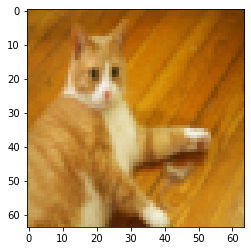

In [32]:
# Example of a picture that was wrongly classified.
index = 19
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))
print(f"y = {str(int(test_set_y[0,index]))}, the model predicted this as a {str(classes[int(d['Y_prediction_test'][0,index])].decode('utf-8'))} picture.")

### Plotting the cost function and the gradients

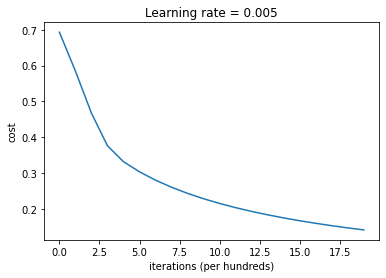

In [33]:
# plotting the learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title(f"Learning rate = {str(d['learning_rate'])}")
plt.show()

**Interpretation**: We can see the cost decreasing. This means that the parameters are being learned. We can train the model even more on the training set by increasing the number of iterations. In that case however we might see the training set accuracy going up, but the test set accuracy going down. This is called overfitting (as the model does not generalize well when dealing with new, unseen cases).

## Further analysis - Choice of learning rate

After building our image classification model we can examine possible choices for the learning rate $\alpha$.

**Note**:
In order for Gradient Descent to work efficiently we must choose the learning rate wisely. The learning rate $\alpha$  determines how rapidly we update the parameters. If the learning rate is too large we may "overshoot" the optimal value. Similarly, if it is too small we will need too many iterations to converge to the optimal values. That is why it is crucial to use a well-tuned learning rate.

### Selecting various learning rates to compare the model's resulting learning curves

learning rate is: 0.01
train accuracy: 99.52153110047847 %
test accuracy: 68.0 %

-------------------------------------------------------

learning rate is: 0.001
train accuracy: 88.99521531100478 %
test accuracy: 64.0 %

-------------------------------------------------------

learning rate is: 0.0001
train accuracy: 68.42105263157895 %
test accuracy: 36.0 %

-------------------------------------------------------



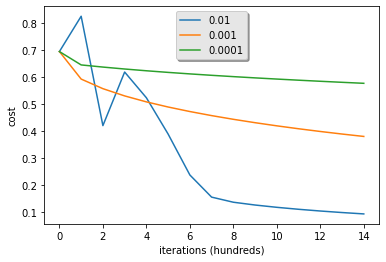

In [34]:
# learning_rates = [0.1, 0.005, 0.00001] # uncomment to try this
# learning_rates = [0.01, 0.005, 0.0005] # uncomment to try this
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.9')
plt.show()

**Interpretation**: 
- Different learning rates result in different costs and thus different predictions results.
- If the learning rate is too large (0.01), the cost may oscillate up and down and it may even diverge (though in this example, using 0.01 still eventually ends up at a good value for the cost). 
- A lower cost doesn't mean a better model. We need to be mindful of overfitting, which takes place when the training accuracy is a lot higher than the test accuracy.
- In deep learning, we should usually choose the learning rate that better minimizes the cost function and if our model overfits, we should use techniques for reducing overfitting.

## Testing using our own image

We can upload an image and check the output of the model to figure whether the algorithm is right (1 = cat, 0 = non-cat).

In [35]:
my_image = "Julie.jpg"   # change this to the name of your image file

# preprocessing the image to fit our algorithm
image = plt.imread(my_image)
image = image/255.
image = image.astype(np.uint8)
my_image = np.array(Image.fromarray(image).resize(size=(num_px,num_px))).reshape((1, num_px*num_px*3)).T
my_predicted_image = predict(d["w"], d["b"], my_image)

# plt.imshow(image)
print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

y = 1.0, your algorithm predicts a "cat" picture.
